# Train vs. Test dataset distributions
Before getting started on this competition I quickly wanted to check the distributions of the test dataset against that of the training dataset, and if possible see how different from each other they are.

In [1]:
import gc
import itertools
from copy import deepcopy

import numpy as np
import pandas as pd

from tqdm import tqdm

from scipy.stats import ks_2samp

from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection

from sklearn import manifold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline

# 1. t-SNE Distribution Overview
To start out I'll take out an equal amount of samples from the train and test dataset (4459 samples from both, i.e. entire training set and sample of test set), and perform a t-SNE on the combined data. I'm scaling all the data with mean-variance, but for columns where we have outliers (> 3x standard deviation) I also do a log-transform prior to scaling.

## 1.0. Data Pre-Processing
Current pre-processing procedure:
* Get 4459 rows from training set and test set and concatenate them
* Columns with standard deviation of 0 in training set removed
* Columns which are duplicate in training set removed
* Log-transform all columns which have significant outliers (> 3x standard deviation)
* Create datasets with: 
    * Mean-variance scale all columns including 0-values!
    * Mean-variance scale all columns **excluding** 0-values!
    

In [2]:
%%time 

# Read train and test files
train_df = pd.read_csv('../input/train.csv')#.sample(SAMPLE_SIZE)
data = train_df.drop(['ID','SUBCLASS'],axis=1)
data = data.applymap(lambda x : 1 if x!='WT' else 0)

test_df = pd.read_csv('../input/test.csv')#.sample(SAMPLE_SIZE)
test_df = test_df.drop('ID',axis=1)
test_df = test_df.applymap(lambda x : 1 if x!='WT' else 0)


<timed exec>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
<timed exec>:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


CPU times: user 17.5 s, sys: 1.21 s, total: 18.7 s
Wall time: 18.6 s


In [3]:
# Get the combined data
total_df = pd.concat([ data, test_df], axis=0)

# Columns to drop because there is no variation in training set
zero_std_cols = test_df.columns[test_df.std() == 0]
total_df.drop(zero_std_cols, axis=1, inplace=True)
print(f">> Removed {len(zero_std_cols)} constant columns")


>> Removed 26 constant columns


In [4]:

# Removing duplicate columns
# Taken from: https://www.kaggle.com/scirpus/santander-poor-mans-tsne
colsToRemove = []
colsScaned = []
dupList = {}
columns = total_df.columns
for i in range(len(columns)-1):
    v = data[columns[i]].values
    dupCols = []
    for j in range(i+1,len(columns)):
        if np.array_equal(v, data[columns[j]].values):
            colsToRemove.append(columns[j])
            if columns[j] not in colsScaned:
                dupCols.append(columns[j]) 
                colsScaned.append(columns[j])
                dupList[columns[i]] = dupCols
colsToRemove = list(set(colsToRemove))
total_df.drop(colsToRemove, axis=1, inplace=True)
print(f">> Dropped {len(colsToRemove)} duplicate columns")


>> Dropped 132 duplicate columns


In [ ]:
colsToRemove

In [5]:
total_df_all = deepcopy(total_df)  

In [6]:
total_df_all

,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2542,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2543,0,0,0,0,0,1,1,1,1,1,...,1,1,0,0,1,0,1,1,0,0
2544,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
data

,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
%%time 
# Go through the columns one at a time (can't do it all at once for this dataset)
            
for col in total_df.columns:
    
    # Detect outliers in this column
    data = total_df[col].values
    data_mean, data_std = np.mean(data), np.std(data)
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in data if x < lower or x > upper]
    
    # If there are crazy high values, do a log-transform
    if len(outliers) > 0:
        non_zero_idx = data != 0
        total_df.loc[non_zero_idx, col] = np.log(data[non_zero_idx])
    
    # Scale non-zero column values
    nonzero_rows = total_df[col] != 0
    total_df.loc[nonzero_rows, col] = scale(total_df.loc[nonzero_rows, col])
    
    # Scale all column values
    total_df_all[col] = scale(total_df_all[col])
    gc.collect()
    


In [14]:
# Train and test
train_idx = range(0, train_df.shape[0])
test_idx = range(train_df.shape[0], len(total_df))

In [15]:
train_idx

range(0, 6201)

In [16]:
test_idx

range(6201, 8747)

With that I end up with two dataframe, pre-processed slightly differently in terms of either scaling with sparse entries or without.

## 1.1. Performing PCA
Since we have so many features, I thought it'd be a good idea to perform PCA prior to the t-SNE to reduce the dimensionality a bit. Arbitrarily I chose to include 1000 PCA components, which includes about 80% of the variation in the dataset, which I think it allright for saying something about the distributions, but also speeding up t-SNE a bit. In the following I show just the visualize only the plots from PCA on the dataset where scaling was performed excluding zeroes.

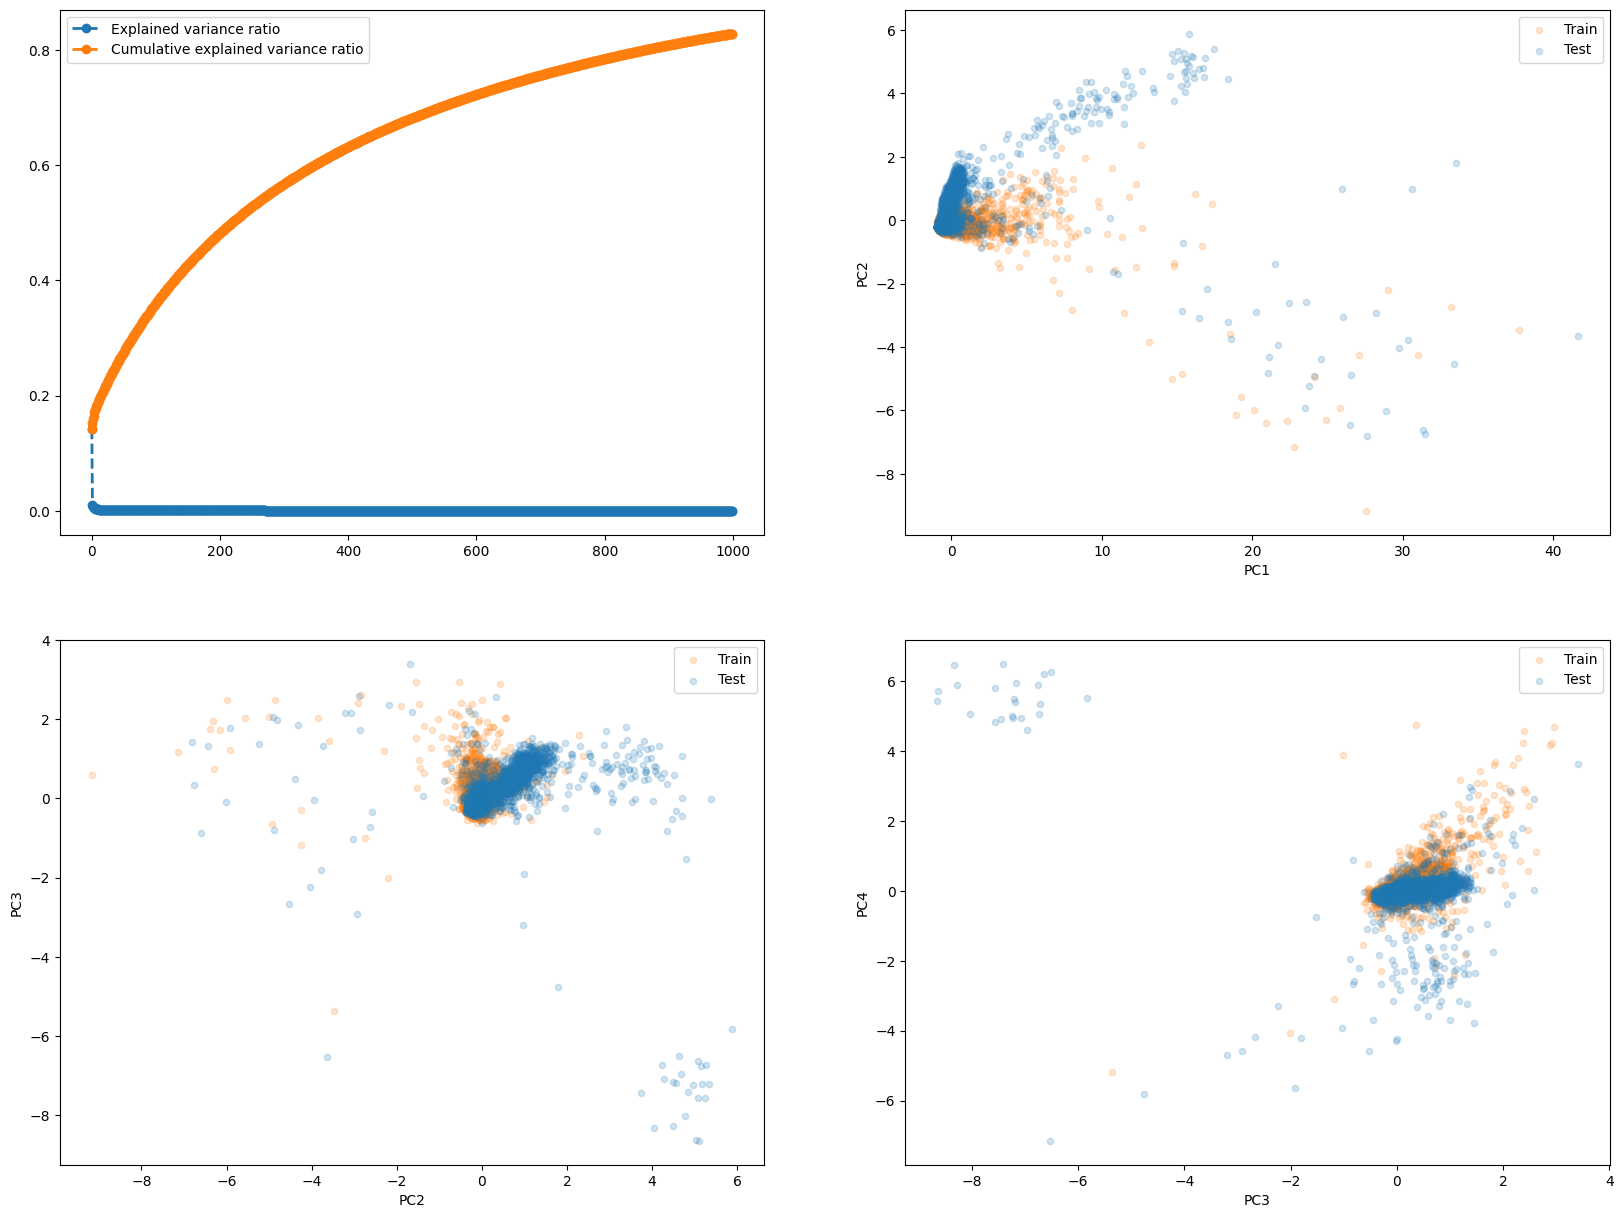

In [17]:
def test_pca(data, create_plots=True):
    """Run PCA analysis, return embedding"""
    
    # Create a PCA object, specifying how many components we wish to keep
    pca = PCA(n_components=1000)

    # Run PCA on scaled numeric dataframe, and retrieve the projected data
    pca_trafo = pca.fit_transform(data)    

    # The transformed data is in a numpy matrix. This may be inconvenient if we want to further
    # process the data, and have a more visual impression of what each column is etc. We therefore
    # put transformed/projected data into new dataframe, where we specify column names and index
    pca_df = pd.DataFrame(
        pca_trafo,
        index=total_df.index,
        columns=["PC" + str(i + 1) for i in range(pca_trafo.shape[1])]
    )

    # Only construct plots if requested
    if create_plots:
        
        # Create two plots next to each other
        _, axes = plt.subplots(2, 2, figsize=(20, 15))
        axes = list(itertools.chain.from_iterable(axes))

        # Plot the explained variance# Plot t 
        axes[0].plot(
            pca.explained_variance_ratio_, "--o", linewidth=2,
            label="Explained variance ratio"
        )

        # Plot the cumulative explained variance
        axes[0].plot(
            pca.explained_variance_ratio_.cumsum(), "--o", linewidth=2,
            label="Cumulative explained variance ratio"
        )

        # Show legend
        axes[0].legend(loc="best", frameon=True)

        # Show biplots
        for i in range(1, 4):

            # Components to be plottet
            x, y = "PC"+str(i), "PC"+str(i+1)

            # Plot biplots
            settings = {'kind': 'scatter', 'ax': axes[i], 'alpha': 0.2, 'x': x, 'y': y}
            pca_df.iloc[train_idx].plot(label='Train', c='#ff7f0e', **settings)
            pca_df.iloc[test_idx].plot(label='Test',  c='#1f77b4', **settings)    

        # Show the plot
        plt.show()
    
    return pca_df

# Run the PCA and get the embedded dimension
pca_df = test_pca(total_df)
pca_df_all = test_pca(total_df_all, create_plots=False)

I included to plot the biplots just for fun, even though only very few percent of the variation are described by those components. Looks fun, and also hints at the training data being more spread out in those components than the test data, which seems more tightly clustered around the center.

## 1.2. Running t-SNE
Having reduced the dimensionality a bit it's now possible to run the t-SNE in about 5min or so, and subsequently plot both training and test data in the embedded 2D space. In the following I do that for both the dataset cases I have prepared to see any differences.

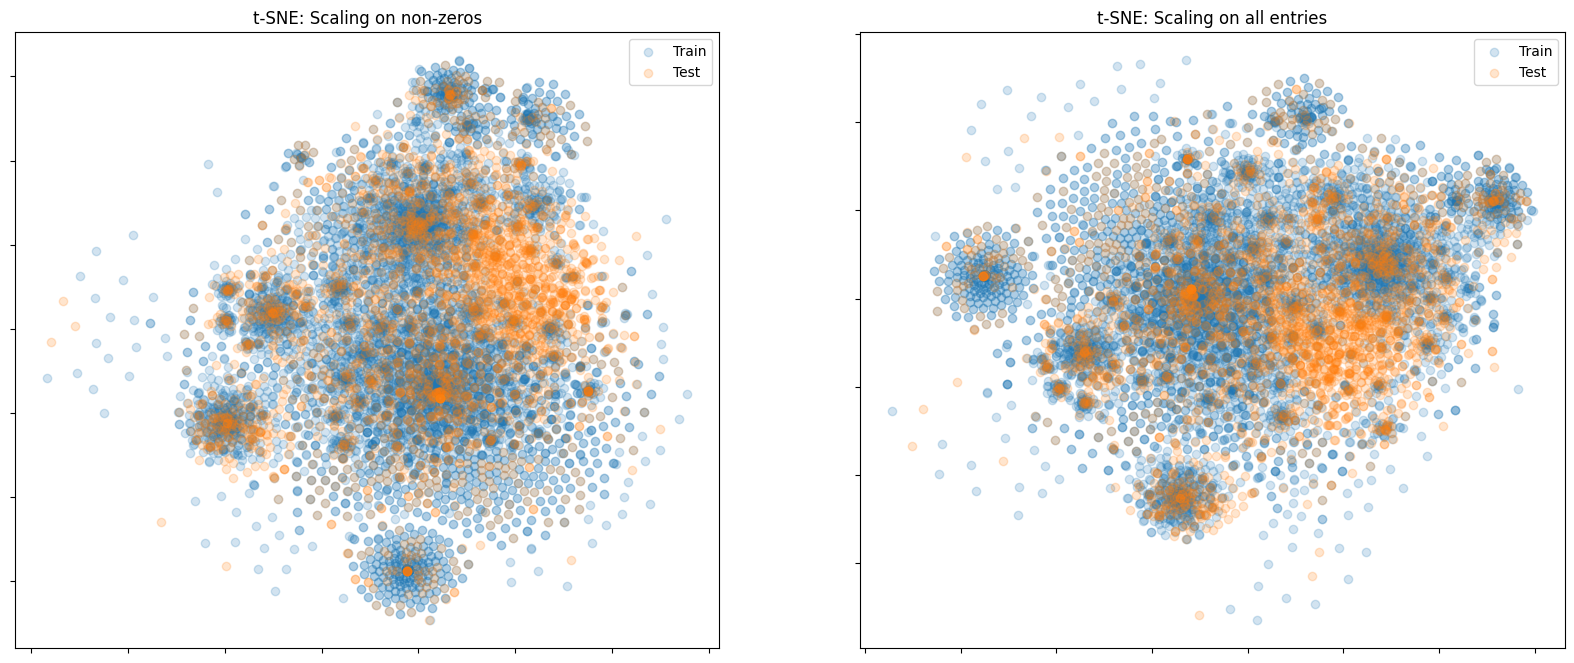

In [18]:
def test_tsne(data, ax=None, title='t-SNE'):
    """Run t-SNE and return embedding"""

    # Run t-SNE
    tsne = TSNE(n_components=2, init='pca')
    Y = tsne.fit_transform(data)

    # Create plot
    for name, idx in zip(["Train", "Test"], [train_idx, test_idx]):
        ax.scatter(Y[idx, 0], Y[idx, 1], label=name, alpha=0.2)
        ax.set_title(title)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
    ax.legend()        
    return Y

# Run t-SNE on PCA embedding
_, axes = plt.subplots(1, 2, figsize=(20, 8))

tsne_df = test_tsne(
    pca_df, axes[0],
    title='t-SNE: Scaling on non-zeros'
)
tsne_df_unique = test_tsne(
    pca_df_all, axes[1],
    title='t-SNE: Scaling on all entries'
)

plt.axis('tight')
plt.show()  

From this is seems like if scaling is performed only on non-zero entries, then the training and test set look more similar. If scaling is performed on all entries it seems like the two datasets are more separated from each other. In a previous notebook I didn't remove duplicate columns or columns with zero standard deviation - in that case even more significant differences were observed. Of course, it's still always important to be careful with t-SNE intepretation in my experience, and it might be worth looking into in more detail; both in terms of t-SNE parameters, pre-processing, etc.

### 1.2.1. t-SNE colored by row-index or zero-count
@avloss commented on this kernel about the fact that the data is time separated, so I thought it'd be interesting to look a bit more into why the t-SNE looks as it does. The two most obvious measures to investigate, that I could come up with off the top of my head, were the index of the rows (as a measure of 'time', assuming data is not shuffled), and the number of zeros for the given rows.

/var/folders/91/x1jkjm3549s21y3h3k_k56q80000gn/T/ipykernel_5907/1835476700.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


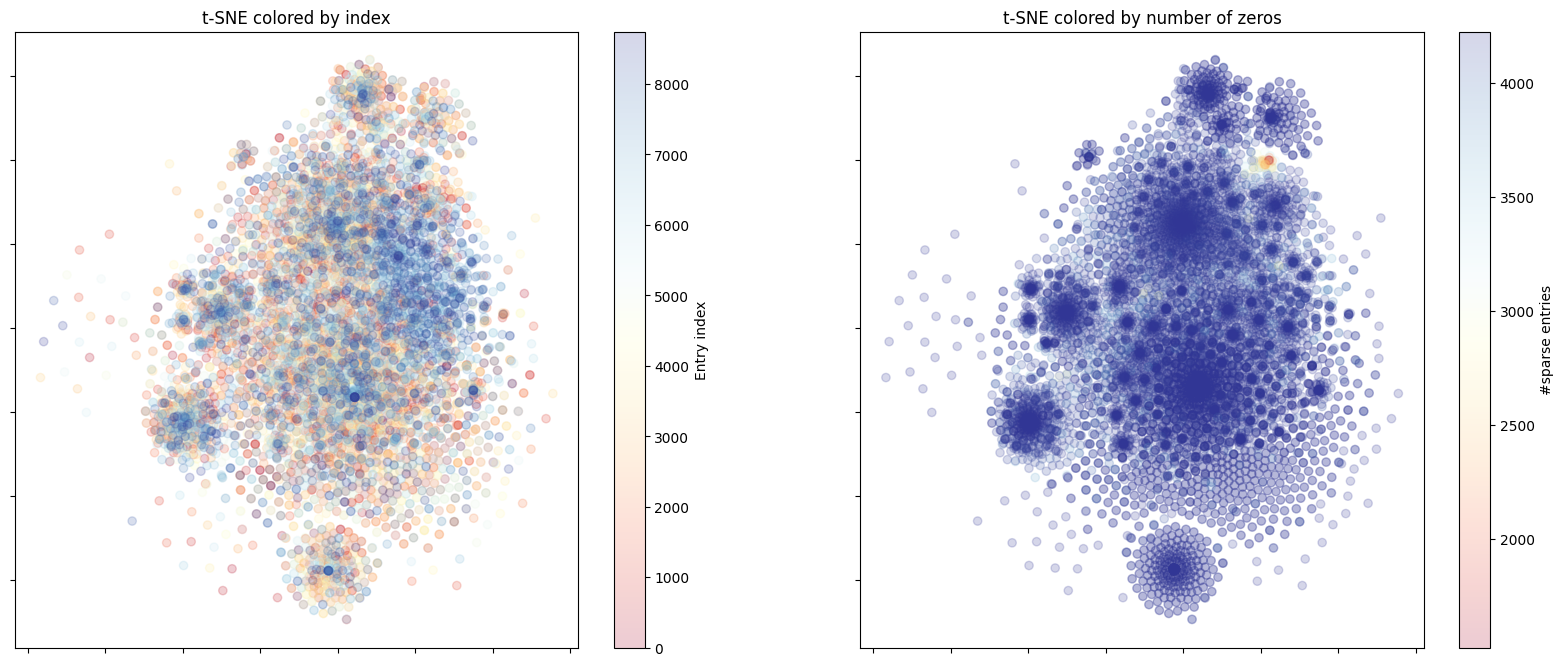

In [21]:
gc.collect()
# Get our color map
cm = plt.cm.get_cmap('RdYlBu')

# Create plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sc = axes[0].scatter(tsne_df[:, 0], tsne_df[:, 1], alpha=0.2, c=range(len(tsne_df)), cmap=cm)
cbar = fig.colorbar(sc, ax=axes[0])
cbar.set_label('Entry index')
axes[0].set_title("t-SNE colored by index")
axes[0].xaxis.set_major_formatter(NullFormatter())
axes[0].yaxis.set_major_formatter(NullFormatter())

zero_count = (total_df == 0).sum(axis=1).values
sc = axes[1].scatter(tsne_df[:, 0], tsne_df[:, 1], alpha=0.2, c=zero_count, cmap=cm)
cbar = fig.colorbar(sc, ax=axes[1])
cbar.set_label('#sparse entries')
axes[1].set_title("t-SNE colored by number of zeros")
axes[1].xaxis.set_major_formatter(NullFormatter())
axes[1].yaxis.set_major_formatter(NullFormatter())


Looks pretty interesting - seems like the higher-index rows are located more at the center of the plot. Also, we see a small cluster of rows with few zero-entries, as well as a few more clusters in the right-hand figure.

### 1.2.2. t-SNE with different perplexities
t-SNE can give some pretty tricky to intepret results depending on the perplexity parameter used. So just to be sure in the following I check for a few different values of the perplexity parameter.

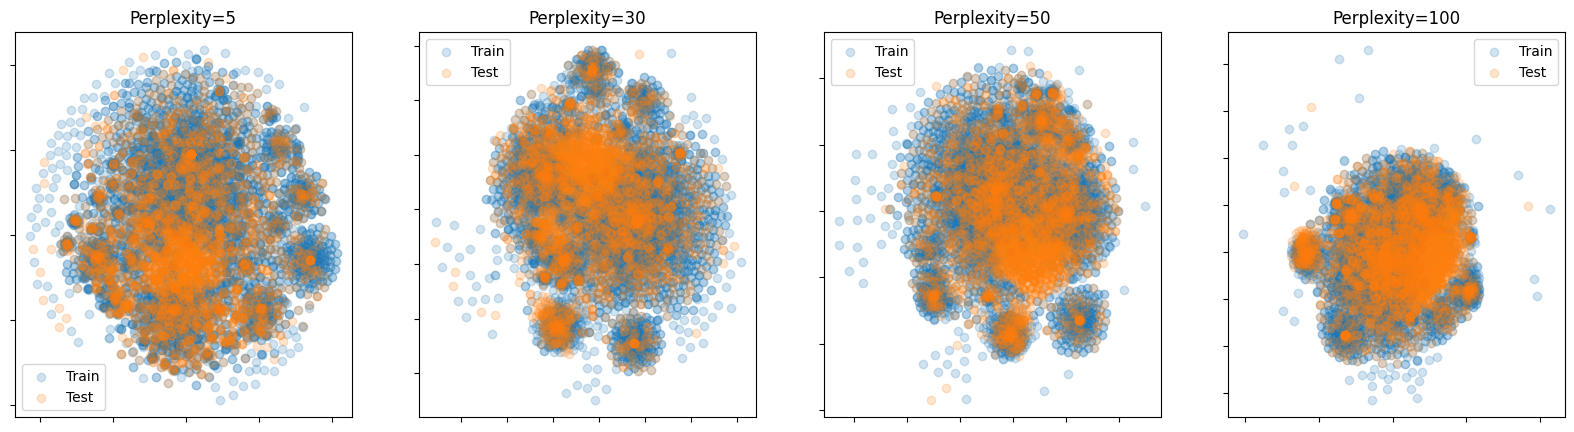

In [22]:
_, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, perplexity in enumerate([5, 30, 50, 100]):
    
    # Create projection
    Y = TSNE(init='pca', perplexity=perplexity).fit_transform(pca_df)
    
    # Plot t-SNE
    for name, idx in zip(["Train", "Test"], [train_idx, test_idx]):
        axes[i].scatter(Y[idx, 0], Y[idx, 1], label=name, alpha=0.2)
    axes[i].set_title("Perplexity=%d" % perplexity)
    axes[i].xaxis.set_major_formatter(NullFormatter())
    axes[i].yaxis.set_major_formatter(NullFormatter())
    axes[i].legend() 

plt.show()

Overall these all look pretty similar and show the same trend, so no need to worry about the perplexity parameter it seems.

### 1.2.3. t-SNE colored by target
For the training set it may be interesting to see how the different target values are separated on the embedded two dimensions.

In [ ]:
#data = train_df.iloc[:,2:].applymap(lambda x : 1 if x!='WT' else 0 )
#data['SUBCLASS'] = train_df['SUBCLASS']

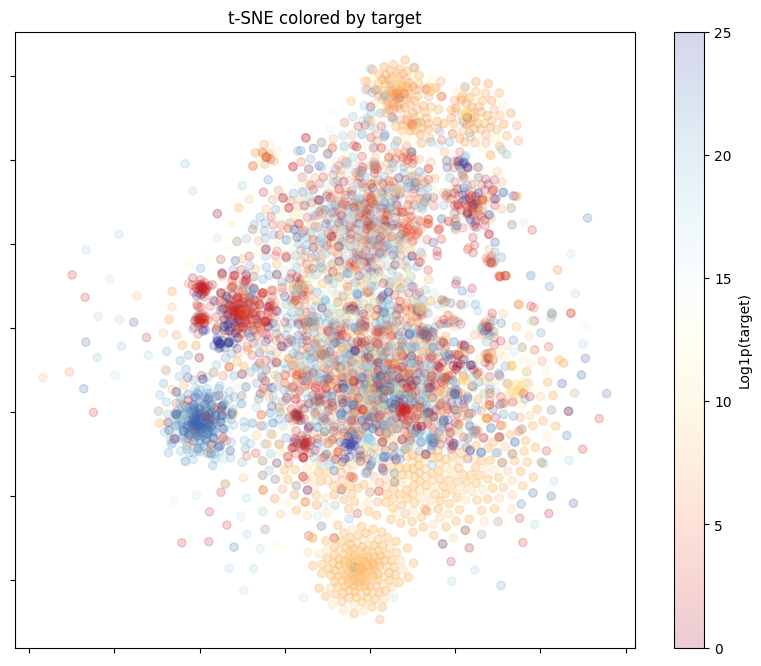

In [23]:
from sklearn.preprocessing import LabelEncoder
enc= LabelEncoder()
train_df['SUBCLASS'] = enc.fit_transform(train_df['SUBCLASS'])
# Create plot



fig, axes = plt.subplots(1, 1, figsize=(10, 8))
sc = axes.scatter(tsne_df[train_idx, 0], tsne_df[train_idx, 1], alpha=0.2, c=train_df['SUBCLASS'], cmap=cm)
cbar = fig.colorbar(sc, ax=axes)
cbar.set_label('Log1p(target)')
axes.set_title("t-SNE colored by target")
axes.xaxis.set_major_formatter(NullFormatter())
axes.yaxis.set_major_formatter(NullFormatter())

Clearly the different train target values are located at different locations in the t-SNE plot.

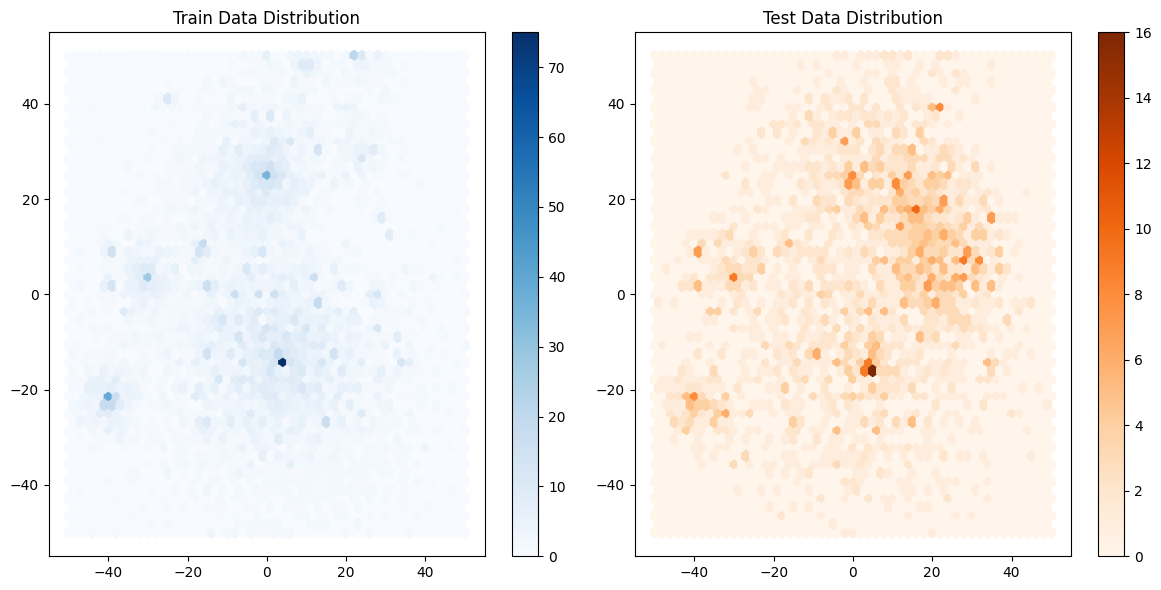

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 가정: tsne_result가 t-SNE로 변환된 데이터의 좌표이고,
# train_idx, test_idx가 각각 train과 test 데이터를 나타내는 인덱스임

# 예시로 t-SNE 변환된 좌표가 있을 때
# tsne_result = 모델을 통해 얻은 t-SNE 결과 (N x 2 배열)

train_tsne = tsne_df[train_idx]  # Train 데이터의 t-SNE 좌표
test_tsne = tsne_df[test_idx]    # Test 데이터의 t-SNE 좌표

# 2D 히스토그램으로 Train/Test 데이터의 밀도 확인
plt.figure(figsize=(12, 6))

# Train 데이터 분포
plt.subplot(1, 2, 1)
plt.hexbin(train_tsne[:, 0], train_tsne[:, 1], gridsize=50, cmap='Blues', extent=[-50, 50, -50, 50])
plt.title('Train Data Distribution')
plt.colorbar()

# Test 데이터 분포
plt.subplot(1, 2, 2)
plt.hexbin(test_tsne[:, 0], test_tsne[:, 1], gridsize=50, cmap='Oranges', extent=[-50, 50, -50, 50])
plt.title('Test Data Distribution')
plt.colorbar()

plt.tight_layout()
plt.show()


In [26]:
from scipy.spatial import KDTree

# Train 데이터의 KDTree를 만들고
train_tree = KDTree(train_tsne)

# 각 Test 데이터 포인트에서 Train 데이터까지의 거리를 계산
distances, _ = train_tree.query(test_tsne)

# 일정 거리 이상으로 떨어져 있는 Test 데이터 포인트 탐색
threshold_distance = 2.0  # 이 값을 조정하여 빈 영역의 기준을 설정
empty_test_indices = np.where(distances > threshold_distance)[0]

print("빈 영역에 있는 Test 데이터 인덱스:", empty_test_indices)


빈 영역에 있는 Test 데이터 인덱스: [   0   20   28   31   33   34   45   64   77   92  109  115  129  168
  171  190  197  206  222  244  248  252  273  276  282  300  313  327
  330  336  349  354  355  375  384  385  419  422  436  460  472  480
  482  500  502  518  544  554  570  581  596  634  654  670  675  686
  725  744  747  774  775  777  778  781  803  813  818  829  848  861
  862  880  899  908  926  937  959  970  973  984  990  996  999 1000
 1003 1040 1050 1068 1094 1108 1119 1173 1178 1179 1188 1189 1193 1195
 1210 1224 1250 1253 1270 1277 1280 1310 1339 1349 1352 1355 1359 1368
 1374 1427 1431 1446 1450 1463 1468 1473 1477 1486 1493 1505 1513 1514
 1519 1532 1539 1547 1551 1559 1563 1576 1581 1607 1636 1644 1652 1669
 1672 1676 1689 1705 1708 1719 1720 1721 1725 1737 1751 1771 1792 1823
 1826 1854 1860 1863 1878 1890 1901 1905 1914 1957 1960 1967 1977 1999
 2004 2018 2019 2030 2033 2038 2045 2054 2063 2067 2084 2093 2094 2127
 2138 2157 2208 2242 2244 2280 2281 2285 2318 2325 232

In [27]:
len(empty_test_indices)

211

In [28]:
from scipy.spatial import KDTree

# Train 데이터의 KDTree를 만들고
train_tree = KDTree(train_tsne)

# 각 Test 데이터 포인트에서 Train 데이터까지의 거리를 계산
distances, _ = train_tree.query(test_tsne)

# 일정 거리 이상으로 떨어져 있는 Test 데이터 포인트 탐색
threshold_distance = 3.0  # 이 값을 조정하여 빈 영역의 기준을 설정
empty_test_indices = np.where(distances > threshold_distance)[0]

print("빈 영역에 있는 Test 데이터 인덱스:", empty_test_indices)


빈 영역에 있는 Test 데이터 인덱스: [  28   31   34   77  115  129  190  206  248  327  349  384  385  419
  436  460  480  570  581  596  634  675  686  775  777  778  818  829
  861  880  899  908  926  959  970  984  999 1003 1040 1050 1108 1119
 1178 1189 1193 1270 1280 1355 1431 1450 1463 1473 1505 1513 1519 1532
 1576 1636 1652 1669 1672 1705 1719 1751 1863 1890 1901 1905 1967 1977
 1999 2019 2030 2033 2038 2084 2093 2094 2208 2242 2244 2281 2318 2325
 2327 2349 2357 2388 2446 2530 2538 2543]


In [29]:
len(empty_test_indices)

92

In [30]:
tar = [15,20,21,25,28,31,34,38,39,48,52,65,68,76
,84,96,98,99,105,107,108,109,114,129,157,158,171,172
,197,210,216,230,240,248,258,268,280,290,292,299,300,304
,308,309,312,313,317,330,346,348,349,353,354,356,362,364
,368,385,400,403,414,419,421,423,425,426,427,429,434,436
,453,457,460,464,465,466,468,470,487,488,502,509,510,514
,526,527,530,531,532,543,554,555,567,569,570,575,580,581
,584,587,591,596,597,601,606,615,620,624,628,629,630,631
,633,634,640,651,653,658,663,665,667,671,675,678,682,685
,688,697,704,717,725,734,744,747,751,753,756,760,764,766
,768,773,774,775,777,778,779,792,795,797,799,801,807,808
,816,818,829,839,847,859,861,862,863,867,870,874,882,888
,892,908,916,918,919,928,933,937,939,946,948,949,959,963
,966,969,973,977,980,983,984,1000,1005,1010,1020,1027,1040,1041
,1043,1050,1051,1052,1054,1062,1068,1070,1079,1080,1087,1094,1097,1103
,1108,1109,1119,1124,1132,1133,1142,1148,1151,1153,1156,1161,1164,1166
,1173,1178,1181,1187,1195,1198,1203,1206,1210,1212,1223,1224,1245,1247
,1253,1274,1277,1280,1288,1289,1291,1298,1316,1317,1324,1339,1343,1345
,1349,1351,1356,1357,1368,1373,1389,1393,1407,1409,1417,1427,1431,1439
,1446,1448,1450,1451,1455,1458,1463,1481,1491,1493,1495,1498,1505,1510
,1522,1525,1529,1530,1537,1546,1547,1548,1550,1553,1570,1576,1582,1589
,1591,1593,1605,1607,1608,1619,1629,1636,1637,1643,1652,1672,1688,1689
,1691,1699,1705,1719,1720,1721,1726,1739,1746,1765,1771,1782,1787,1792
,1796,1800,1803,1814,1823,1837,1842,1848,1852,1870,1877,1878,1887,1888
,1897,1907,1916,1917,1923,1928,1938,1944,1956,1964,1966,1967,1991,1996
,2011,2019,2020,2021,2025,2026,2034,2036,2053,2054,2057,2067,2070,2075
,2076,2077,2078,2094,2103,2105,2108,2110,2123,2133,2138,2145,2148,2151
,2154,2160,2172,2180,2194,2195,2209,2228,2231,2237,2259,2266,2269,2272
,2283,2285,2289,2290,2303,2304,2305,2316,2318,2321,2323,2329,2330,2331
,2339,2345,2349,2354,2360,2361,2366,2376,2380,2387,2388,2391,2413,2415
,2416,2417,2420,2433,2435,2436,2441,2444,2445,2450,2454,2456,2461,2462
,2475,2485,2488,2493,2500,2505,2514,2516,2519,2524,2525,2527,2528,2531
,2537,2541]


In [32]:
len(set(empty_test_indices).intersection(set(tar)))

46

# 2. Classification of Test vs. Train
Another good check is to see how well we can classify whether a given entry belongs to test or training dataset - if it is possible to do this reasonably well, that is an indication of differences between the two dataset distributions. I'll just run a simple shuffled 10-fold cross-validation with a basic random forest model to see how well it performs this task. First let's try that classification on the case where scaling is performed on all entries:

In [ ]:
def test_prediction(data):
    """Try to classify train/test samples from total dataframe"""

    # Create a target which is 1 for training rows, 0 for test rows
    y = np.zeros(len(data))
    y[train_idx] = 1

    # Perform shuffled CV predictions of train/test label
    predictions = cross_val_predict(
        ExtraTreesClassifier(n_estimators=100, n_jobs=4),
        data, y,
        cv=StratifiedKFold(
            n_splits=10,
            shuffle=True,
            random_state=42
        )
    )

    # Show the classification report
    print(classification_report(y, predictions))
    
# Run classification on total raw data
test_prediction(total_df_all)

On the current notebook this gives about a 0.71 f1 score, which means we can do this prediction quite well, indicating some significant differences between the datasets. Let us try on the dataset where we only scaled non-zero values:

In [ ]:
test_prediction(total_df)

This reduced the f1 score a little bit down to 0.68; corresponding to what we observed in the t-SNE analysis, but still it's apparently quite easy for the model to decently well distinguish between train and test - considering the very simple classifcation model used here.

# 3. Feature-by-feature distribution similarity
Next let us try to look at the problem feature-by-feature, and perform Kolomogorov-Smirnov tests to see if the distribution in test and training set is similar. I'll use the function [scipy.stats.ks_2samp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp) from scipy to run the tests. For all those features where the distributions are highly distinguishable, we may benefit from ignoring those columns, so as to avoid overfitting on training data. In the following I just identify those columns, and plot the distributions as a sanity check for some of the features

100%|██████████| 4226/4226 [00:15<00:00, 275.80it/s]


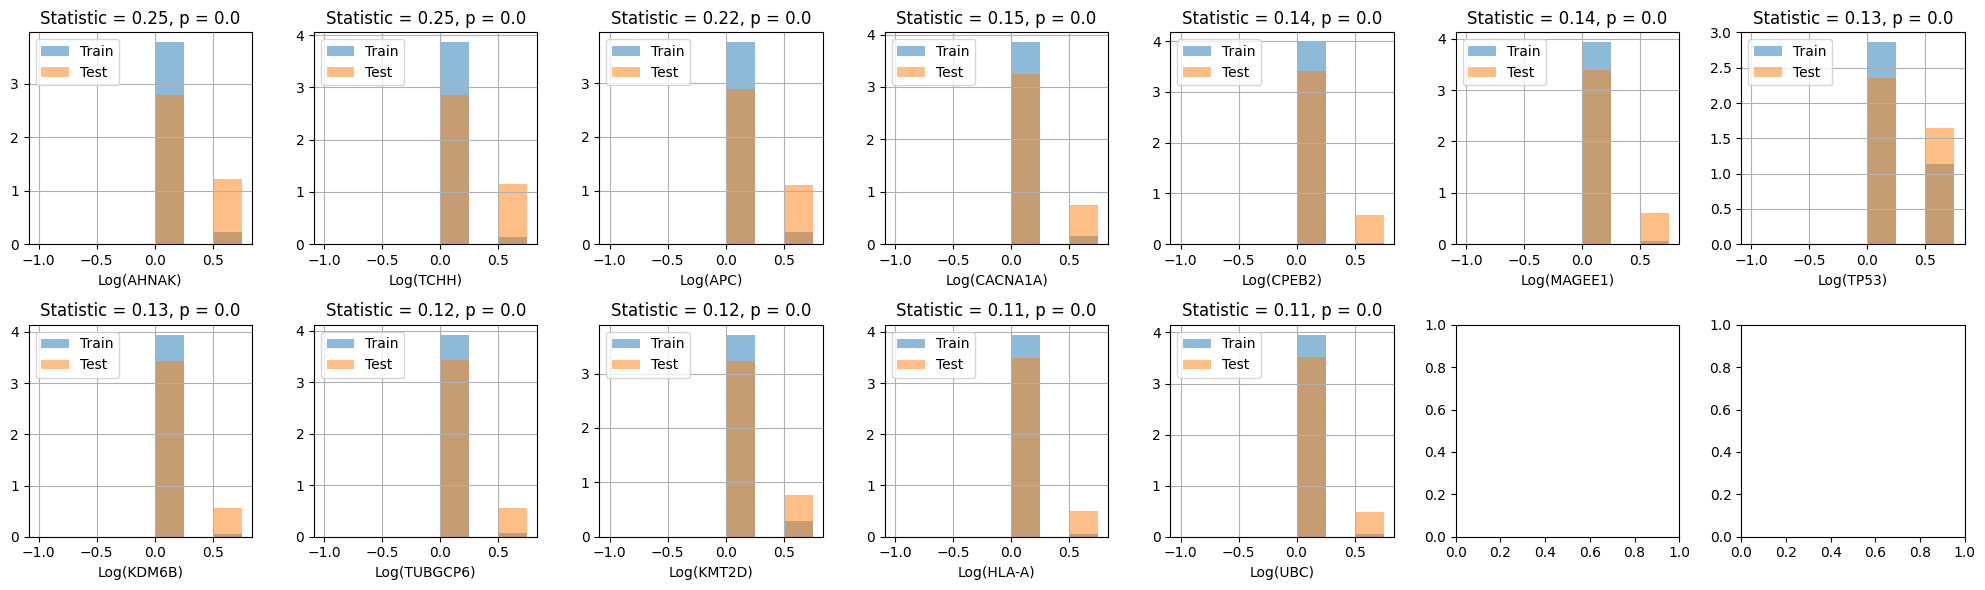

In [24]:
def get_diff_columns(train_df, test_df, show_plots=True, show_all=False, threshold=0.1):
    """Use KS to estimate columns where distributions differ a lot from each other"""

    # Find the columns where the distributions are very different
    diff_data = []
    for col in tqdm(train_df.columns):
        statistic, pvalue = ks_2samp(
            train_df[col].values, 
            test_df[col].values
        )
        if pvalue <= 0.05 and np.abs(statistic) > threshold:
            diff_data.append({'feature': col, 'p': np.round(pvalue, 5), 'statistic': np.round(np.abs(statistic), 2)})

    # Put the differences into a dataframe
    diff_df = pd.DataFrame(diff_data).sort_values(by='statistic', ascending=False)

    if show_plots:
        # Let us see the distributions of these columns to confirm they are indeed different
        n_cols = 7
        if show_all:
            n_rows = int(len(diff_df) / 7)
        else:
            n_rows = 2
        _, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))
        axes = [x for l in axes for x in l]

        # Create plots
        for i, (_, row) in enumerate(diff_df.iterrows()):
            if i >= len(axes):
                break
            extreme = np.max(np.abs(train_df[row.feature].tolist() + test_df[row.feature].tolist()))
            train_df.loc[:, row.feature].apply(np.log1p).hist(
                ax=axes[i], alpha=0.5, label='Train', density=True,
                bins=np.arange(-extreme, extreme, 0.25)
            )
            test_df.loc[:, row.feature].apply(np.log1p).hist(
                ax=axes[i], alpha=0.5, label='Test', density=True,
                bins=np.arange(-extreme, extreme, 0.25)
            )
            axes[i].set_title(f"Statistic = {row.statistic}, p = {row.p}")
            axes[i].set_xlabel(f'Log({row.feature})')
            axes[i].legend()

        plt.tight_layout()
        plt.show()
        
    return diff_df

# Get the columns which differ a lot between test and train
diff_df = get_diff_columns(total_df.iloc[train_idx], total_df.iloc[test_idx])

On my run it dropped about 150 features. Let's try a classification report again to see if we can distinguish test from train.

In [ ]:
# Run classification on total raw data
print(f">> Dropping {len(diff_df)} features based on KS tests")
test_prediction(
    total_df.drop(diff_df.feature.values, axis=1)
)

Here we actually see lower score, down from 68% to 62%, meaning train and test are more similar. I've not tested these things with any regressors yet, but I'd think it might be interesting to drop some if not all of these features which may enable the model to overfit on training data. I'm not sure Kolmogorov–Smirnov is neccesarily the absolute best statistical test for comparing these kinda-discrete distributions - I've tried only running it on non-zero entries, but in that case we end up removing many more features, while still allowing the model to easily distinguish between train and test based on the zeroes. Suggestions on how to approach this more thoroughly would be appreciated.

# 4. Decomposition Feature
So far I've only looked at PCA components, but most kernels look at several decomposition methods, so it may be interesting to look at t-SNE of these 10-50 components of each method instead of 1000 PCA components. Furthermore, it's interesting to see how well we can classify test/train based on this reduced feature space.



In [ ]:
total_df

In [ ]:

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
COMPONENTS = 20
cm = plt.cm.get_cmap('RdYlBu')
#cm2 = plt.cm.get_cmap('gist_ncar')
cm2 = plt.cm.get_cmap('rainbow')
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
# List of decomposition methods to use
methods = [
    TruncatedSVD(n_components=COMPONENTS),
    PCA(n_components=COMPONENTS),
    FastICA(n_components=COMPONENTS),
    GaussianRandomProjection(n_components=COMPONENTS, eps=0.1),
    SparseRandomProjection(n_components=COMPONENTS, dense_output=True)    
]

# Run all the methods
embeddings = []
for method in methods:
    name = method.__class__.__name__    
    embeddings.append(
        pd.DataFrame(method.fit_transform(total_df), columns=[f"{name}_{i}" for i in range(COMPONENTS)])
    )
    print(f">> Ran {name}")
    
# Put all components into one dataframe
components_df = pd.concat(embeddings, axis=1)

# Prepare plot
_, axes = plt.subplots(1, 3, figsize=(20, 5))

# Run t-SNE on components
tsne_df = test_tsne(
    components_df, axes[0],
    title='t-SNE: with decomposition features'
)

# Color by index
sc = axes[1].scatter(tsne_df[:, 0], tsne_df[:, 1], alpha=0.2, c=range(len(tsne_df)), cmap=cm)
cbar = fig.colorbar(sc, ax=axes[1])
cbar.set_label('Entry index')
axes[1].set_title("t-SNE colored by index")
axes[1].xaxis.set_major_formatter(ticker.NullFormatter())
axes[1].yaxis.set_major_formatter(ticker.NullFormatter())

# Color by target
sc = axes[2].scatter(tsne_df[train_idx, 0], tsne_df[train_idx, 1], alpha=0.4, c=train_df.SUBCLASS, cmap=cm2)
cbar = fig.colorbar(sc, ax=axes[2])
cbar.set_label('Log1p(target)')
axes[2].set_title("t-SNE colored by target")
axes[2].xaxis.set_major_formatter(ticker.NullFormatter())
axes[2].yaxis.set_major_formatter(ticker.NullFormatter())

plt.axis('tight')
plt.show()  

Let us check how well we can classify train from test with these feature:

In [ ]:
test_prediction(components_df)

So here we get a classification f1 score of about 0.83, which is pretty bad I would say. Clearly the test and training are very different from each other looking at these components. Let us try to use the KS tests again to eliminate columns that are significantly different from each other.

In [ ]:
# Get the columns which differ a lot between test and train
diff_df = get_diff_columns(
    components_df.iloc[train_idx], components_df.iloc[test_idx],
    threshold=0.1
)

# Run classification on total raw data
print(f">> Dropping {len(diff_df)} features based on KS tests")
test_prediction(
    components_df.drop(diff_df.feature.values, axis=1)
)

So by dropping 78 features we're down to an f1 score of 0.6. I've not tried testing any of this against either local CV score or public LB score, and probably all these features should not be dropped, but I imagine some of them could be leading to overfitting on the training set.

To be updated.